# **Part-of-Speech Tagging with the Kaggle NER Dataset**

This notebook demonstrates the implementation of a token classification model using an LSTM network for the Part-of-Speech (PoS) tagging task, utilizing the [Kaggle NER Dataset](https://www.kaggle.com/datasets/namanj27/ner-dataset).

### **Imports**

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.core.display import HTML
from google.colab import drive

### **Parameters**

In [4]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
epochs = 10
batch_size = 64
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED= 123
vocab_size = None #Include the entire vocabulary, encompassing the padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

The dataset was downloaded from the provided link on the official Kaggle website and then uploaded to my personal Google Drive. It comprises four columns: ``# Sentence``, ``Word``, ``POS``, and ``Tag``. For the PoS tagging task, we will utilize all columns except for ``Tag``, as it is used for another token classification task, namely [Named Entity Recognition (NER)](https://github.com/JersonGB22/TokenClassification-TensorFlow/blob/main/models_lstm/NER_LSTM_Kaggle.ipynb).

**Guide to PoS Tags**

- **NN**: Singular Common Noun (e.g., "dog", "car")
- **NNP**: Singular Proper Noun (e.g., "John", "London")
- **IN**: Preposition or Subordinating Conjunction (e.g., "in", "of", "like")
- **DT**: Determiner (e.g., "the", "a", "this")
- **JJ**: Adjective (e.g., "big", "green", "first")
- **NNS**: Plural Common Noun (e.g., "dogs", "cars")
- **.**: Period or End-of-Sentence Punctuation
- **VBD**: Past Tense Verb (e.g., "was", "went")
- **,**: Comma
- **VBN**: Past Participle Verb (e.g., "eaten", "seen")
- **VBZ**: Third Person Singular Present Tense Verb (e.g., "runs", "likes")
- **CD**: Cardinal Number (e.g., "one", "two", "100")
- **VB**: Base Form Verb (e.g., "run", "eat")
- **CC**: Coordinating Conjunction (e.g., "and", "but", "or")
- **TO**: "to" as Preposition or Infinitive Marker (e.g., "to go", "to eat")
- **RB**: Adverb (e.g., "quickly", "very", "well")
- **VBG**: Gerund or Present Participle Verb (e.g., "running", "eating")
- **VBP**: Present Tense Verb (non-third person singular) (e.g., "run", "eat")
- **PRP**: Personal Pronoun (e.g., "he", "she", "it")
- **POS**: Possessive Ending (e.g., "'s")
- **PRP\$**: Possessive Pronoun (e.g., "his", "her", "their")
- **MD**: Modal Verb (e.g., "can", "will", "should")
- **``**: Opening Quotation Mark
- **WDT**: Wh-determiner (e.g., "which", "that")
- **JJS**: Superlative Adjective (e.g., "biggest", "best")
- **JJR**: Comparative Adjective (e.g., "bigger", "better")
- **WP**: Wh-pronoun (e.g., "who", "what")
- **NNPS**: Plural Proper Noun (e.g., "Americans", "Smiths")
- **RP**: Particle (e.g., "up" in "give up")
- **WRB**: Wh-adverb (e.g., "where", "when")
- **\$**: Dollar Sign
- **RBR**: Comparative Adverb (e.g., "better", "more")
- **:**: Colon
- **EX**: Existential "there" (e.g., "there is")
- **RRB**: Right Parenthesis
- **LRB**: Left Parenthesis
- **RBS**: Superlative Adverb (e.g., "best", "most")
- **;**: Semicolon
- **PDT**: Predeterminer (e.g., "all", "both")
- **WP$**: Wh-possessive Pronoun (e.g., "whose")
- **UH**: Interjection (e.g., "oh", "wow")
- **FW**: Foreign Word (e.g., "et cetera", "de facto")

In [6]:
# Unzip the dataset
!unzip -q /content/drive/MyDrive/Datasets/ner_datasetreference.csv.zip

In [7]:
# Load the dataset
df = pd.read_csv("/content/ner_datasetreference.csv", encoding="latin1")

# Completing missing values in the 'Sentence #' column using previous values
df["Sentence #"].fillna(method="ffill", inplace=True)

# Remove sentences containing at least one null Word
sentences_nan = df[df.Word.isna()]["Sentence #"].unique()
df = df[~df["Sentence #"].isin(sentences_nan)]

# Variable to view the count of values for each 'POS'
pos_counts = df.POS.value_counts()

# Grouping words and POS by sentence
df = df.groupby("Sentence #")[["Word", "POS"]].agg(lambda x: " ".join(x))
df

,Word,POS
Sentence #,,
Sentence: 1,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...
Sentence: 10,Iranian officials say they expect to get acces...,JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT...
Sentence: 100,Helicopter gunships Saturday pounded militant ...,"NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ..."
Sentence: 1000,They left after a tense hour-long standoff wit...,PRP VBD IN DT NN JJ NN IN NN NNS .
Sentence: 10000,U.N. relief coordinator Jan Egeland said Sunda...,"NNP NN NN NNP NNP VBD NNP , NNP , JJ CC JJ JJ ..."
...,...,...
Sentence: 9995,Opposition leader Mir Hossein Mousavi has said...,NNP NN NNP NNP NNP VBZ VBN PRP VBZ TO VB CC NN...
Sentence: 9996,"On Thursday , Iranian state media published a ...","IN NNP , JJ NN NNS VBN DT NN IN DT JJ JJ NNS V..."
Sentence: 9997,"Following Iran 's disputed June 12 elections ,...","VBG NNP POS JJ NNP CD NNS , NNS NNS VBD NNS IN..."


In [8]:
pos_counts

POS
NN      145789
NNP     131421
IN      120978
DT       98439
JJ       78405
NNS      75829
.        47821
VBD      39372
,        32756
VBN      32314
VBZ      24959
CD       24691
VB       24209
CC       23715
TO       23058
RB       20251
VBG      19124
VBP      16156
PRP      13316
POS      11256
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3033
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: count, dtype: int64

It can be observed that the dataset is unbalanced regarding the "POS" values, with the most affected ones ranging from ``:`` to ``FW``.

In [9]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47949 entries, Sentence: 1 to Sentence: 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    47949 non-null  object
 1   POS     47949 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


**Splitting the dataframe into training (70%), validation (15%) y testing (15%) sets**

In [10]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=SEED)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=SEED)

del df, df_val_test #Remove to free memory

len(df_train), len(df_val), len(df_test)

(33564, 7192, 7193)

**Creation of Sentence and Label Encoders**

To tokenize the sentences, the `TextVectorization` layer is employed, which encodes the text into indices by frequency order, considering up to `vocab_size`. The index tensors are padded with zeros to reach the length of the longest sequence in the batch unless a fixed value for `output_sequence_length` is specified. In this case, the `standardize` argument is set to None since punctuation marks should not be removed or sentences converted to lowercase, as this could affect the PoS tagging task. A capital letter within a sentence may indicate an entity, and all words are separated by spaces, including punctuation marks.

For tokenizing the labels, the `tf.keras.preprocessing.text.Tokenizer` function is used. Similar to sentences, the labels are not converted to lowercase, and punctuation marks are not removed since the labels are already predefined. Additionally, padding is added up to the longest sequence using the `tf.keras.utils.pad_sequences` function to match the tokenized sentences.

In [11]:
tf.random.set_seed(SEED)

encoder_x = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize=None)
encoder_x.adapt(df_train.Word.values)
vocab_x = np.array(encoder_x.get_vocabulary())

print(encoder_x.vocabulary_size())
vocab_x[:10]

30180


array(['', '[UNK]', 'the', '.', ',', 'of', 'in', 'to', 'a', 'and'],
      dtype='<U64')

In [12]:
encoder_y = tf.keras.preprocessing.text.Tokenizer(lower=False, filters="")
encoder_y.fit_on_texts(df_train.POS.values)

vocab_y = encoder_y.word_index
vocab_y_inv = encoder_y.index_word
print(len(vocab_y))
vocab_y

42


{'NN': 1,
 'NNP': 2,
 'IN': 3,
 'DT': 4,
 'JJ': 5,
 'NNS': 6,
 '.': 7,
 'VBD': 8,
 ',': 9,
 'VBN': 10,
 'VBZ': 11,
 'CD': 12,
 'VB': 13,
 'CC': 14,
 'TO': 15,
 'RB': 16,
 'VBG': 17,
 'VBP': 18,
 'PRP': 19,
 'POS': 20,
 'PRP$': 21,
 'MD': 22,
 '``': 23,
 'WDT': 24,
 'JJS': 25,
 'JJR': 26,
 'WP': 27,
 'NNPS': 28,
 'RP': 29,
 'WRB': 30,
 '$': 31,
 'RBR': 32,
 ':': 33,
 'EX': 34,
 'RRB': 35,
 'LRB': 36,
 'RBS': 37,
 ';': 38,
 'PDT': 39,
 'WP$': 40,
 'UH': 41,
 'FW': 42}

In [13]:
def generate_dataset(df, shuffle=False):
  sentences_ids = encoder_x(df.Word.values)
  labels_ids = encoder_y.texts_to_sequences(df.POS.values)
  labels_ids = tf.keras.utils.pad_sequences(labels_ids, padding="post")

  dataset = tf.data.Dataset.from_tensor_slices((sentences_ids, labels_ids))
  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

  return dataset

In [14]:
train_dataset = generate_dataset(df_train, shuffle=True)
val_dataset = generate_dataset(df_val)
test_dataset = generate_dataset(df_test)

del df_train, df_val

In [15]:
# Visualizing a tokenized batch
for texts, labels in train_dataset.take(1):
  print(texts, "\n")
  print(labels)

tf.Tensor(
[[   10    68   359 ...     0     0     0]
 [   10    52    14 ...     0     0     0]
 [   10 16266   333 ...     0     0     0]
 ...
 [   48  1384  1950 ...     0     0     0]
 [  394   616     6 ...     0     0     0]
 [  705     6   246 ...     0     0     0]], shape=(64, 104), dtype=int64) 

tf.Tensor(
[[ 4  5  6 ...  0  0  0]
 [ 4  1 11 ...  0  0  0]
 [ 4  2  1 ...  0  0  0]
 ...
 [ 4  2  2 ...  0  0  0]
 [16  1  3 ...  0  0  0]
 [14  3  2 ...  0  0  0]], shape=(64, 104), dtype=int32)


In [16]:
# Viewing the results of tokenization

id = 2

print(texts[id].numpy())
decoded_texts = " ".join(vocab_x[texts[id]])
print(decoded_texts, "\n")

print(labels[id].numpy())
decoded_labels = encoder_y.sequences_to_texts([labels[id].numpy()])[0]
print(decoded_labels)

[   10 16266   333  2753     2 14435     5     8 21401  1993    16    64
  4086  2959  2326 28960  1170 14710     4   140  6112     9 26919 14996
     4     2  5249    55  4616     2  6694     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
The Filmyard deal marks the culmination of a drawn-out sale that had attracted various Los Angeles-based rival bidders , including Bob and Harvey Weinstein , the brothers who founded the studio .                                                                         

[ 4  2  1 11  4  1  3  4  5  1 24  8 10  5  2  5  5  6  9 17  2 14  2  2
  9  4  6 27  8  4  1  

### **Build the Model**

In [17]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=encoder_x.vocabulary_size(),
        output_dim=embedding_dim,
        mask_zero=True, #Indicates that the value 0 is a padding value that should be masked
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Dense(len(vocab_y)+1, activation="softmax") #+1 for the padding token (0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3863040   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 43)          11051     
                                                                 
Total params: 4137259 (15.78 MB)
Trainable params: 4137259 (15.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


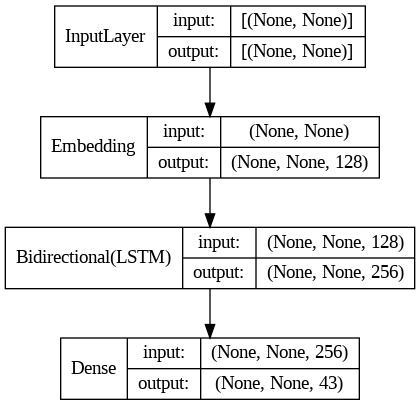

In [18]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0), #Ignore label 0 when calculating loss and accuracy
    metrics=["accuracy"]
)

# Callback to stop training early if validation accuracy does not improve for 2 epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [20]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/10
525/525 [==============================] - 43s 59ms/step - loss: 0.2148 - accuracy: 0.9405 - val_loss: 0.0728 - val_accuracy: 0.9776
Epoch 2/10
525/525 [==============================] - 13s 25ms/step - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.0756 - val_accuracy: 0.9778
Epoch 3/10
525/525 [==============================] - 13s 24ms/step - loss: 0.0281 - accuracy: 0.9905 - val_loss: 0.0825 - val_accuracy: 0.9779
Epoch 4/10
525/525 [==============================] - 14s 26ms/step - loss: 0.0237 - accuracy: 0.9919 - val_loss: 0.0923 - val_accuracy: 0.9772
Epoch 5/10
525/525 [==============================] - 13s 24ms/step - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.0986 - val_accuracy: 0.9761


**Save model**

In [57]:
model.save("/content/drive/MyDrive/models/PoS_LSTM_Kaggle.keras")

### **Dataset Evaluation**

In [21]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.01913917250931263, 0.9934983849525452]
[0.08254312723875046, 0.9779108762741089]
[0.07995039224624634, 0.9782075881958008]


**Consolidating the accuracy of the testing set**

In [22]:
labels_test = test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_test = np.array(list(labels_test))

labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)
mask = (labels_test != 0).astype(np.float32)
matches_true_pred = (labels_test == labels_test_pred).astype(np.float32)
matches_true_pred *= mask

masked_accuracy = np.sum(matches_true_pred) / np.sum(mask)
masked_accuracy

0.9782076

After just 3 epochs, the training dataset achieves an accuracy of **99.3%**, while the validation dataset accuracy is **97.8%** and the test dataset accuracy is also **97.8%**. If we were to train for more epochs, the training dataset accuracy would increase to 100%, but the validation and test set accuracies would decrease. The model performs excellently but shows signs of slight overfitting, which we effectively mitigate with the callback that stops training when the validation accuracy does not improve for 2 consecutive epochs. Of course, to achieve even better results, it would be advisable to expand the training dataset and/or utilize more robust architectures like Transformers. However, the model performs quite well in part-of-speech tagging, as will be seen later, making the use of Transformers unnecessary.

In [3]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [24]:
plot_metrics()
plot_metrics(metric="accuracy")

**Images for GitHub**

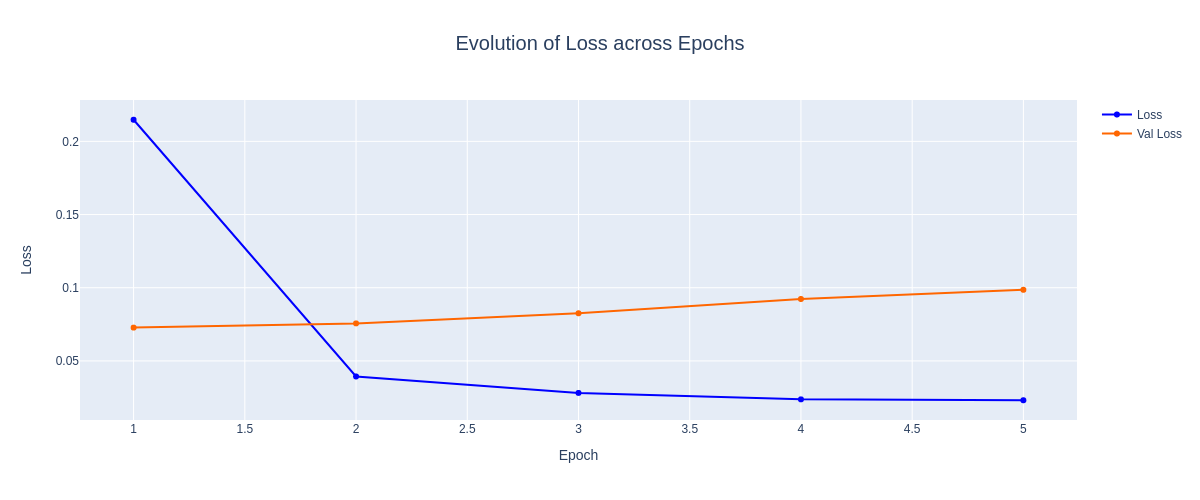

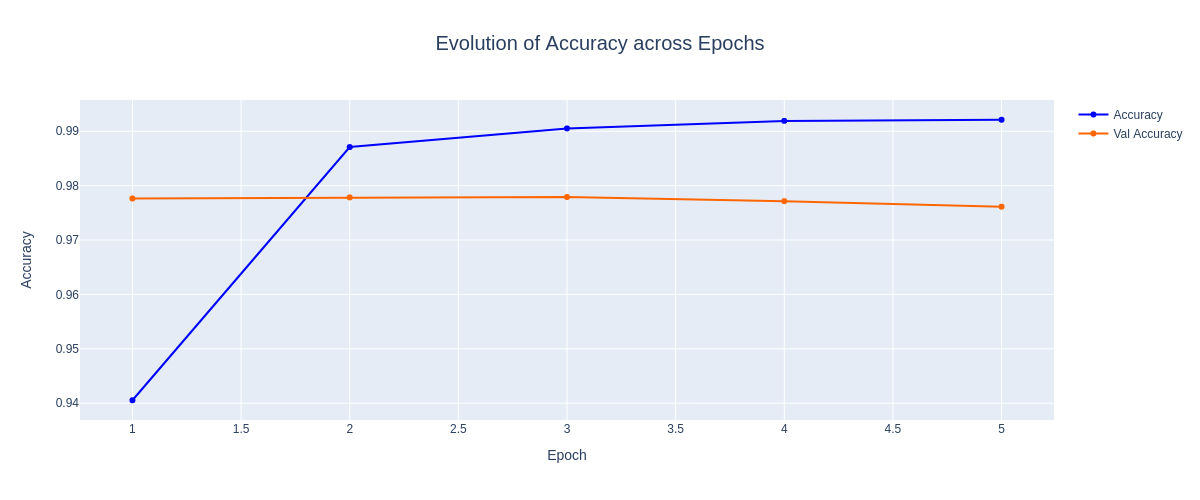

In [4]:
plot_metrics(renderer="png")
plot_metrics(renderer="png", metric="accuracy")

### **Predictions with the trained model**

In [59]:
# Loading the trained model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/PoS_LSTM_Kaggle.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3863040   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 43)          11051     
                                                                 
Total params: 4137259 (15.78 MB)
Trainable params: 4137259 (15.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Function to predict sentence labels

def predict_label(sentences, labels=None, random=True, indice=0):
  indice = np.random.choice(len(sentences)) if random else indice

  sentence = sentences[indice]
  sentence_ids = encoder_x([sentence])

  label_ids_pred = model.predict(sentence_ids, verbose=0).squeeze()
  label_ids_pred = np.argmax(label_ids_pred, axis=-1)

  display(HTML(f"<b>Sentence:</b> {sentence}<br><br>"))
  html_content = """
  <table style="border-collapse: separate; border-spacing: 15px; text-align: center;">
    <tr>
      <th>Word</th>
      <th>Predicted PoS</th>
  """

  if labels is not None:
    label_colors = {"incorrect":"red", "correct":"green"}
    label = labels[indice]
    label_ids = encoder_y.texts_to_sequences([label])[0]
    html_content += "<th>True PoS</th>"
  html_content += "</tr>"

  # Consider only the labels that are not padding (0)
  id_mask = len(sentence.split(" "))

  for i in range(id_mask):
    html_content += f"""
      <tr>
      <td>{vocab_x[sentence_ids[0][i]]}</td>
      <td>{vocab_y_inv[label_ids_pred[i]]}</td>
    """

    if labels is not None:
      result = "correct" if label_ids[i] == label_ids_pred[i] else "incorrect"

      html_content += f"""
        <td>{vocab_y_inv[label_ids[i]]}</td>
        <td><b><span style="color:{label_colors[result]}">{result}</span></b></td>
      """
    html_content += "</tr>"

  html_content += "</table>"
  display(HTML(html_content))

#### **Test Dataset**

In [31]:
sentences, labels = df_test.Word.values, df_test.POS.values

In [62]:
predict_label(sentences, labels, random=False)

In [35]:
predict_label(sentences, labels)

In [37]:
predict_label(sentences, labels, random=False, indice=100)

In [39]:
predict_label(sentences, labels)

In [40]:
predict_label(sentences, labels, random=False, indice=2093)

#### **Other Sentences**

In [52]:
sentence = ["George Smith , the White House director of trade and manufacturing policy of U.S , said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall ."]
predict_label(sentence)

Word,Predicted PoS
George,NNP
Smith,NNP
",",","
the,DT
White,NNP
House,NNP
director,NN
of,IN
trade,NN
and,CC


In [53]:
sentence = ["In Tokyo , Japan , the United Nations announced on Monday that they will hold a global climate summit in December . The event , which will include representatives from over 150 countries , aims to address the urgent issues of climate change and global warming . UN Secretary-General Antonio Guterres emphasized the need for immediate action to protect the planet ."]
predict_label(sentence)


Word,Predicted PoS
In,IN
Tokyo,NNP
",",","
Japan,NNP
",",","
the,DT
United,NNP
Nations,NNP
announced,VBD
on,IN


In [54]:
sentence = ["Barack Obama , the former President of the United States , delivered a speech at the United Nations General Assembly in New York City on Tuesday . He discussed global cooperation in addressing challenges such as climate change , terrorism , and economic inequality . Obama urged world leaders to work together for a better future ."]
predict_label(sentence)

Word,Predicted PoS
Barack,NNP
Obama,NNP
",",","
the,DT
former,JJ
President,NNP
of,IN
the,DT
United,NNP
States,NNPS


There are only two errors: ``President`` should be ``NN`` (common noun) instead of ``NNP`` (proper noun), and ``delivered`` should be ``VBD`` (past tense verb) instead of ``VBN`` (past participle).

**Conclusion:** It is evident that the model excels in accurately identifying each part of sentences in the test set, as well as in others not included in the Kaggle NER Dataset, even when they are long or complex. However, it exhibits slight inaccuracies in classifying certain labels, which are minimal as seen in the predicted examples. Therefore, while the model performs excellently, improving its performance would necessitate expanding the training dataset to include sentences containing minority labels to balance them with other labels. Additionally, as mentioned earlier, considering the use of Transformer networks would be advisable, but the LSTM model is already quite robust, so I believe it may not be necessary.